## **This is evalution test for the project SIRA in GSOC'25 under the umbrella organization HumanAI.**
### The test is to do evalution test for any other project and I have choose **[AI-Powered Behavioral Analysis for Suicide Prevention, Substance Use, and Mental Health Crisis Detection with Longitudinal Geospatial Crisis Trend Analysis](https://humanai.foundation/gsoc/2025/proposal_ISSR3.html) - [ISSR 3 Test](https://docs.google.com/document/d/e/2PACX-1vQfC8gkrSx_ycYkIOdae5sJ-fuqn2UA9nLtGqA5egBuwNKMNZpi_NBR0MRnnqdWt8WYqznE6x9_DIO0/pub)**

In [ ]:
# install necessary libraries
!pip install --upgrade praw
!pip install vaderSentiment --use-deprecated=legacy-resolver
!pip install textblob --use-deprecated=legacy-resolver
!pip install datasets --use-deprecated=legacy-resolver
!pip install nltk --use-deprecated=legacy-resolver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and p

In [ ]:
# import libraries
import requests
import requests.auth
import pandas as pd
import numpy as np
import torch
import praw
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
from sklearn.model_selection import train_test_split
from datasets import Dataset,ClassLabel
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import folium
import pandas as pd
from branca.colormap import linear
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Task 1**: Social Media Data Extraction & Preprocessing (API Handling & Text Cleaning)

In [ ]:
# using Reddit api to extract posts
# Not using search queries because they rarely gives relevant data

reddit = praw.Reddit(
    client_id="XXXXXXXXXXXXXXXXXXXXXX",
    client_secret="XXXXXXXXXXXXXXXXXXXXX",
    user_agent="XXXXXXXXXXXXXXXXXXXXXXX",
    check_for_async=False
)

# testing
for submission in reddit.subreddit("depression").hot(limit=5):
    print(submission.title)

Our most-broken and least-understood rules is "helpers may not invite private contact as a first resort", so we've made a new wiki to explain it
Regular check-in post, with information about our rules and wikis
I have cried so much, im tired
I've spent 90% of my freetime in bed since I was 12
Every Time I Fall Asleep I’m Hoping my eyes Never Open


In [ ]:
# Function to get posts beyond 1000 limit
def get_posts(subredditname, limit=5000):
    print("getting subreddit "+subredditname+"...")
    posts = []
    last_post = None
    subreddit = reddit.subreddit(subredditname)
    while len(posts) < limit:
        if last_post:
            new_posts = list(subreddit.hot(limit=1111, params={'before': last_post}))
        else:
            new_posts = list(subreddit.hot(limit=None))

        if not new_posts:
            break

        posts.extend(new_posts)
        last_post = new_posts[-1].fullname

        time.sleep(1)

    return posts[:limit]


# Clean the text removing unwanted charecters, emojis, links etc
def cleantext(text):
  text = str(text).lower()
  text = re.sub(r'\[.*?\]', '', text)
  text = re.sub(r'https?://\S+|www\.\S+', '', text)
  text = re.sub(r'\s+', ' ', text.strip())
  text = re.sub(r'<.*?>+', '', text)
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub(r'\n', '', text)
  text = re.sub(r'\w*\d\w*', '', text)
  text = re.sub(r'[^\x00-\x7F]+', '', text)
  text = remove_stopwords(text)
  return text


# Function to retrieve data from the post object
def get_data(post):
  # get post Post ID, Timestamp, Title, Content, Auther, likes, comments, subreddit
  content=cleantext(post.selftext)
  return [post.id, post.created_utc, post.title, content, post.selftext, post.author, post.ups, post.num_comments, post.subreddit_name_prefixed.replace("r/","")]

# Stop word removal
def remove_stopwords(text):
    words = text.split()
    clean_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(clean_words)

stop_words = set(stopwords.words('english'))


In [ ]:
# Extract posts from subreddits related to mental health, suicide, addiction etc and store

subreddits = ["depression","DrugAddiction","Addiction","SuicideWatch","SelfHarm"]


data=[]
c=0
for sr in subreddits:
  posts = get_posts(sr,limit = 10000)
  for post in posts:
    data.append(get_data(post))
    c+=1

df=pd.DataFrame(data,columns=['ID', 'Timestamp', 'Title', 'Content', 'Content_row', 'Auther', 'Likes', 'Comments', 'Subreddit'])


getting subreddit depression...
getting subreddit DrugAddiction...
getting subreddit Addiction...
getting subreddit SuicideWatch...
getting subreddit SelfHarm...


In [ ]:
# save the df
df.to_csv("data.csv",index=False)
df.head(10)

,ID,Timestamp,Title,Content,Content_row,Auther,Likes,Comments,Subreddit
0,doqwow,1.572361e+09,Our most-broken and least-understood rules is ...,understand people reply immediately op invitat...,We understand that most people who reply immed...,SQLwitch,2363,177,depression
1,1frqlk0,1.727565e+09,"Regular check-in post, with information about ...",welcome rdepressions checkin post place take m...,Welcome to /r/depression's check-in post - a p...,SQLwitch,42,263,depression
2,1jie7of,1.742776e+09,"I have cried so much, im tired",name josh im im lot pain friends spend time th...,"My name is Josh, im 33 and im in a lot of pain...",CucumberCultural3760,126,32,depression
3,1ji2co9,1.742745e+09,I've spent 90% of my freetime in bed since I w...,title says ive bedrotting since spend time lay...,As the title says I've been bedrotting since I...,hylskrik,292,27,depression
4,1jiawlg,1.742767e+09,Being an underachiever with depression is a do...,least overachievers peoples respect theyre see...,At least overachievers have other people’s res...,Nitrogen70,88,7,depression
5,1jik7b0,1.742797e+09,Every Time I Fall Asleep I’m Hoping my eyes Ne...,im life virtual im unemployed keep getting rej...,I’m 18 about to 19 and once I am My life is Vi...,ValTorni,19,2,depression
6,1jicxob,1.742772e+09,IT REALLY DID GET BETTER,year bet rotting way scared talk woman really ...,Before this year I was bet rotting being way t...,plaguepsycho419,55,29,depression
7,1jidgvr,1.742774e+09,i don't wanna get better.,honestly find comfort depressed happy much wan...,i honestly find more comfort in being depresse...,currencycollectors,38,4,depression
8,1jif66w,1.742779e+09,Gender roles make me feel worthless,im got late start life im independent dont gre...,I’m 28m and I got a late start in life. I’m no...,throwaway_harhar,25,11,depression
9,1jikxz5,1.742800e+09,I just don’t like existing,theres anything particular fucked life im poor...,It’s not that there’s anything in particular f...,OnlyMixture6406,8,2,depression


## **Task 2.1**: Sentiment & Crisis Risk Classification (NLP & Text Processing)

Using VEDAR Sentiment analyzer

In [ ]:
# Applying VADER
# Tested Textblob, VADER is better

analyzer = SentimentIntensityAnalyzer()

# Function to run VADER model
def get_sentiment(text):
  score = analyzer.polarity_scores(text)["compound"]
  if score<-0.3:
    return "Negative"
  elif score<0.3:
    return "Nuetral"
  else:
    return "Positive"

texts = ["I just want to commit suicide","I am so happy today","I am sad but I am ok"]
for text in texts:
  print(text," : ",get_sentiment(text))

# test the model
text = input("Enter your post: ")
print("sentiment: ",get_sentiment(text))

I just want to commit suicide  :  Negative
I am so happy today  :  Positive
I am sad but I am ok  :  Nuetral
Enter your post: I had a coffee today
sentiment:  Nuetral


In [ ]:
df = pd.read_csv(r"/content/data.csv")

In [ ]:
# Checking on posts retrieved
# result, it works good most of the time, but not great on lengthy posts
posts_1 = df['Content_row'].tolist()
for post in posts_1[2:12]:
  print(post," : ",get_sentiment(post))
  print('======')



My name is Josh, im 33 and im in a lot of pain. I have no friends and i spend most of my time thinking about the past trauma. I just want somebody to tell me that im not crazy. Am i equal to everyone else?  :  Negative
As the title says I've been bedrotting since I was 12. I spend most of my time laying in my bed. I can't sit upright in chairs because my posture is only used to laying in bed. I enjoy eating in my bed. I feel safe in my bed.

When I was younger I didn't spend all my time in bed because I had friends and activities to do. I could sit upright in chairs without being in pain. I don't know how to live like that anymore. It's been almost a decade since, I'm not familiar with it.

For fun I crochet in bed. I draw in bed. I watch videos in bed. I get a dopamine rush when I think about all the fun things I could do with my life. I fantasize about how good I would have it if I had friends and didn't rot away in bed everyday.

I don't know if this is hope or delusion. I make an e

<ipython-input-20-2933f663fbfb>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


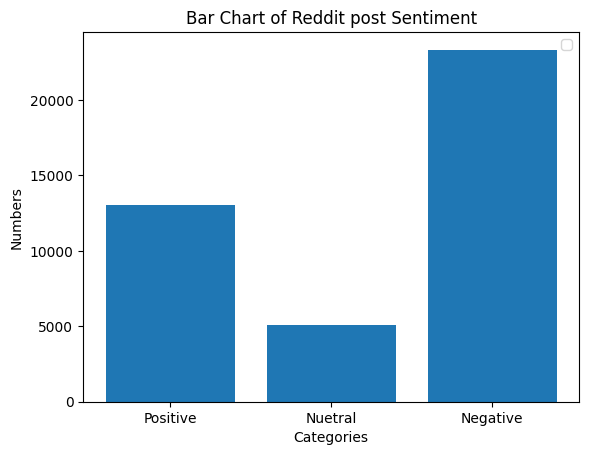

In [ ]:

results = {"Positive":0,"Nuetral":0,"Negative":0,}
posts_1 = [post for post in posts_1 if post not in [None, np.nan]]
for post in posts_1:
  results[get_sentiment(post)]+=1

plt.bar(list(results.keys()), list(results.values()))

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Numbers")
plt.title("Bar Chart of Reddit post Sentiment")

# Add legend
plt.legend()

# Show the plot
plt.show()

## **Task 2.2**: Using Bert to detect high-risk crisis terms.

In [ ]:
# Use TF-IDF or Word Embeddings (BERT, Word2Vec) to detect high-risk crisis terms.
# Training bert-uncase from custom dataset from kaggle
# Dataset: https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch

# Load dataset
new_df = pd.read_csv(r'/content/Suicide_Detection.csv')
new_df['label']=new_df['class']
new_df=new_df[['text','label']]
new_df.head()

,text,label
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
# preprocess
# shuffle and take a small chunk to avoid long training time

dd={"suicide":1,"non-suicide":0}
# coding the label and cleaning the text
new_df['text'] = new_df['text'].apply(cleantext)
new_df['label']=new_df['label'].replace(dd)

new_df = new_df.sample(frac=1).reset_index(drop=True)
new_df=new_df[0:20000]
new_df.head(10)

<ipython-input-9-e3700cae5911>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df['label']=new_df['label'].replace(dd)


,text,label
0,hangingthinking drop hanging balcony terrified...,1
1,happy holloween may final day spooktober shall...,0
2,go online aloneat moment suicide doesnt seems ...,1
3,want diei well recently one trigger another im...,1
4,remember happened yesterday day changed november,0
5,friend tried commit suicide night help himone ...,1
6,wanna hang family leaves mallive always alone ...,1
7,discord mods keep asking im,0
8,guess consider vent fuck iti wanna die im even...,1
9,loneliness hello suffered loneliness isolation...,1


In [ ]:
# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(new_df['text'].tolist(), new_df['label'].tolist(), test_size=0.2)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Dataset wrapper object
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}  # Keep tensors on CPU
        item['labels'] = torch.tensor(self.labels[idx])  # Keep tensors on CPU
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.158400,0.186256
2,0.103200,0.122147
3,0.079600,0.164121


{'eval_loss': 0.16412091255187988,
 'eval_runtime': 25.2512,
 'eval_samples_per_second': 158.408,
 'eval_steps_per_second': 2.495,
 'epoch': 3.0}

In [ ]:
# Save the model and test

model.save_pretrained('./my_model')
tokenizer.save_pretrained('./my_model')


# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained('./my_model')
tokenizer = BertTokenizer.from_pretrained('./my_model')

# Create a pipeline
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

def bertclassification(text):
  result = classifier(text)
  if result[0]['label']=='LABEL_1' and result[0]['score']>0.9:
    sentiment = "High-Risk"
  elif result[0]['label']=='LABEL_1' and result[0]['score']<0.9:
    sentiment = "Moderate Concern"
  elif result[0]['label']=='LABEL_0' and result[0]['score']>0.9:
    sentiment = "Moderate Concern"
  else:
    sentiment = "Low Concern"
  return sentiment
# Example prediction
text = "I should end my life, I don't know what to do anymore, no money, no life, addicted to drugs"
print(bertclassification(text))
text = "I am doing ok today, went out and played some football, then had food with my girlfriend"
print(bertclassification(text))


Device set to use cuda:0


Moderate Concern
Moderate Concern


In [ ]:
classifier(post)[0]

{'label': 'LABEL_0', 'score': 0.9984997510910034}

In [ ]:
# Checking on real data

for post in posts_1[2:11]:
  try:
    print(post)
    result = classifier(post)
    print(result)
    sentiment = bertclassification(post)
    print(sentiment)
    print()
  except Exception as e:
    print(e)
    continue



Token indices sequence length is longer than the specified maximum sequence length for this model (742 > 512). Running this sequence through the model will result in indexing errors


My name is Josh, im 33 and im in a lot of pain. I have no friends and i spend most of my time thinking about the past trauma. I just want somebody to tell me that im not crazy. Am i equal to everyone else?
[{'label': 'LABEL_0', 'score': 0.9923921227455139}]
Moderate Concern

As the title says I've been bedrotting since I was 12. I spend most of my time laying in my bed. I can't sit upright in chairs because my posture is only used to laying in bed. I enjoy eating in my bed. I feel safe in my bed.

When I was younger I didn't spend all my time in bed because I had friends and activities to do. I could sit upright in chairs without being in pain. I don't know how to live like that anymore. It's been almost a decade since, I'm not familiar with it.

For fun I crochet in bed. I draw in bed. I watch videos in bed. I get a dopamine rush when I think about all the fun things I could do with my life. I fantasize about how good I would have it if I had friends and didn't rot away in bed everyda

<ipython-input-23-8dd47c97d5db>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


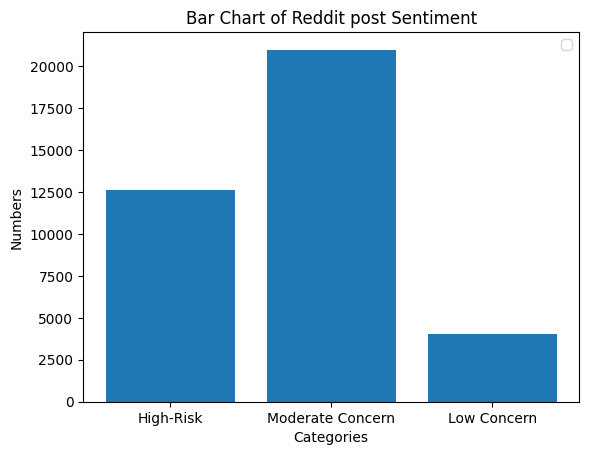

In [ ]:
results = {"High-Risk":0,"Moderate Concern":0,"Low Concern":0,}

for post in posts_1[2:]:
  try:
    sentiment = bertclassification(post)
    results[sentiment]+=1
  except Exception as e:
    #print(e)
    continue

plt.bar(list(results.keys()), list(results.values()))

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Numbers")
plt.title("Bar Chart of Reddit post Sentiment")

# Add legend
plt.legend()

# Show the plot
plt.show()

## **Task 3**: Crisis Geolocation & Mapping

I couldn't find a single post with location mentioning, it feels like people wanted to stay anonymous, but there is a high chance that while people anonymous these people interract with their curresponding city subreddits, using that assumption here I have checked users location based on their interactions with city subreddits.

In [ ]:
# Creating a database of cities
# Database source: https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/table/?disjunctive.cou_name_en&sort=ascii_name&location=2,0.90932,-0.05452&basemap=jawg.light

# The downloaded dataset csv is corrupted, hence reading the row file and processing
with open("C:\\Users\\haleel\\Downloads\\tempgsoc\\cities.csv", 'r', encoding='utf-8') as f:
    lines = f.readlines()

columns=["name","country","country_code","population","coordinates"]
data_cities=[]
cities=[]
c=0
lines = lines[1:]

for line in lines:
  line_s = line.split(";")
  if len(line_s)==20:
    c+=1
    # Taking cities with population more than 30k
    if int(line_s[13])>30000:
      city = line_s[2].replace(" ","")
      city = city.replace("'","")
      data_cities.append([city,line_s[7],line_s[6],line_s[13],line_s[19]])
      cities.append(city.lower())

data = pd.DataFrame(data_cities[:], columns=columns)
print(len(cities))
data.head()

15984


,name,country,country_code,population,coordinates
0,NIAValencia,Philippines,PH,83591,"7.90639, 125.09417\n"
1,Toledo,Philippines,PH,207314,"10.3773, 123.6386\n"
2,Tinongan,Philippines,PH,62146,"10.215, 123.03528\n"
3,Solano,Philippines,PH,36222,"16.51918, 121.18124\n"
4,SantaAna,Philippines,PH,47158,"15.0955, 120.767\n"


In [ ]:
# Check every user's comment history available and see where they are from.
# Taking a sample from the data since it takes a long time to scan through
# The users comment data
df=pd.read_csv("C:\\Users\\haleel\\Downloads\\tempgsoc\\data.csv")
users = df['Auther'].tolist()
users = [user for user in users if user not in [None or np.nan]]
usercitydirectory = {}
srvisits = {}

c=0
index=5001
for username in users[index+2:]:
  visitedsubs=[]
  try:
    # Part-1
    user = reddit.redditor(username)
    comments=user.comments.new(limit=1000)
    time.sleep(1)
    #print("user checked")
    for comment in comments:
      # assumed visited city subreddit
      city=comment.subreddit.display_name.lower()
      # check whether it is a city name
      if city in cities:
        if username in usercitydirectory:
          if city in usercitydirectory[username]:
            usercitydirectory[username][city]+=1
          else:
            usercitydirectory[username][city] = 1
        else:
          usercitydirectory[username] = {}
          usercitydirectory[username][city] = 1

      # Part-2

      # subreddit visited
      sr=comment.subreddit.display_name.lower()
      if sr not in srvisits and sr not in visitedsubs:
        srvisits[sr]=1
        visitedsubs.append(sr)
      elif sr not in visitedsubs:
        srvisits[sr]+=1
        visitedsubs.append(sr)
    c+=1
    if c==10000:
      print("10000 users scanned")
      break
  except Exception as e:
    print("error",e)
    continue



error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error received 403 HTTP response
error rece

In [ ]:
# save the variables as it is expensive to run it everytime
with open("srvisits.json", "w", encoding="utf-8") as f:
    json.dump(srvisits, f, indent=4)

with open("usercitydirectory.json", "w", encoding="utf-8") as f:
    json.dump(usercitydirectory, f, indent=4)

In [ ]:
# check the if city is detected
limit=10
for user in usercitydirectory:
  print(user, usercitydirectory[user])
  limit-=1
  if limit==0:
    break

hylskrik {'oslo': 1}
Nitrogen70 {'batman': 2}
currencycollectors {'kandi': 1}
impadfootbutemo {'launceston': 1}
yogesh_gosavi {'nashik': 56}
Mysterious-Lead3621 {'london': 3}
Shonkbonk {'sanantonio': 63, 'austin': 61, 'sanmarcos': 157, 'houston': 27, 'sugarland': 1, 'asheville': 1, 'dallas': 1, 'kansascity': 1, 'greenville': 1}
ExplanationDazzling1 {'chicago': 9, 'istanbul': 3, 'denver': 5, 'atlanta': 1, 'logansquare': 2, 'logan': 2}
Blue_Steel_415 {'rome': 1}
Horror_Average_5141 {'pittsburgh': 11}


In [ ]:
# Get the distribuition of location of Authors
# And count of Authors in each city.
city_count = {}

for user in usercitydirectory:
  for city in usercitydirectory[user]:
    if city in city_count:
        city_count[city] += 1
    else:
        city_count[city] = 1

# Check the algorithm
limit=10
for city in city_count:
  print(city,city_count[city])
  limit-=1
  if limit==0:
    break

oslo 1
batman 6
kandi 3
launceston 1
nashik 1
london 10
sanantonio 1
austin 4
sanmarcos 1
houston 5


In [ ]:
# Plot the distribuition

# Collect coordinates from cities dataframe
fullcitydata = {
    "City": [],
    "Latitude": [],
    "Longitude": [],
    "Value": []
}

def getcords(city):
  for _,row in data.iterrows():
    if row['name'].lower() == city:
      cords = row['coordinates'].strip('\n')
      return [float(i) for i in cords.split(', ')]

for city in city_count:
  # only considering cities with more than 1 entry
  if city_count[city]>=2:
    fullcitydata["City"].append(city)
    fullcitydata["Value"].append(city_count[city])
    lat,lon = getcords(city)
    fullcitydata["Latitude"].append(lat)
    fullcitydata["Longitude"].append(lon)


In [ ]:
# removing city names gay and batman because those subreddits are dedicated for
# different purpose
for srr in ['gay','batman']:
    ii = fullcitydata['City'].index(srr)
    fullcitydata['City'].pop(ii)
    fullcitydata['Latitude'].pop(ii)
    fullcitydata['Longitude'].pop(ii)
    fullcitydata['Value'].pop(ii)

In [ ]:
# plot the cities with the count as color griadient.
# more darker color means a concentratin of users there

df = pd.DataFrame(fullcitydata)

# Create a base map
m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=4)

# Create a colormap based on values
colormap = linear.YlOrRd_09.scale(df["Value"].min(), df["Value"].max())  # Yellow to Red gradient

# Add markers to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=(row["Latitude"], row["Longitude"]),
        radius=15,  # Size of marker
        color=colormap(row["Value"]),
        fill=True,
        fill_color=colormap(row["Value"]),
        fill_opacity=0.7,
        popup=f"{row['City']}: {row['Value']}"
    ).add_to(m)

# Add color legend to the map
colormap.caption = "Value Intensity"
colormap.add_to(m)

# Save and display the map
m.save("map.html")
m


## Some Extra work, trying to gain some more insights from this data

In [ ]:
# Check every users comment history
# To see which all subreddits people visit the most
# Note that even a person visits a sr more than once it is counted as once


sorted_srvisits = dict(sorted(srvisits.items(), key=lambda x: x[1]))
srs=[]
count = []
limit=20
for sr in sorted_srvisits:
  if not sorted_srvisits[sr]<=20:
    srs.append(sr)
    count.append(sorted_srvisits[sr])

C:\Users\haleel\AppData\Local\Temp\ipykernel_20448\3575300548.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


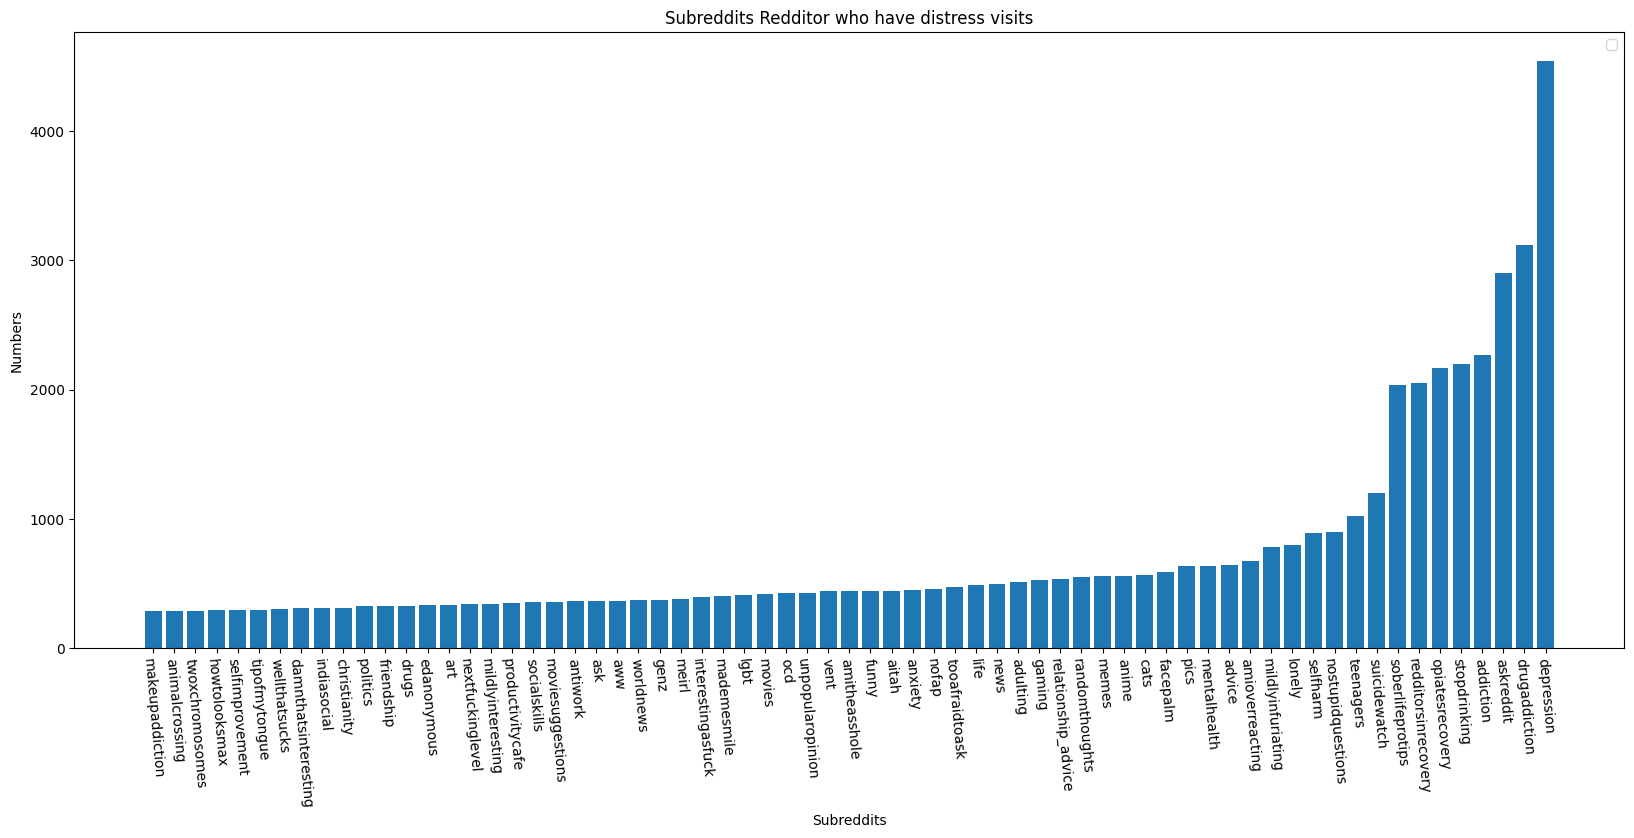

In [ ]:
sorted_srvisits = dict(sorted(srvisits.items(), key=lambda x: x[1]))
srs=[]
count = []
limit=280
for sr in sorted_srvisits:
  if not sorted_srvisits[sr]<=limit:
    srs.append(sr)
    count.append(sorted_srvisits[sr])

plt.figure(figsize=(20, 8))
plt.bar(srs, count)

# Add labels and title
plt.xlabel("Subreddits")
plt.ylabel("Numbers")
plt.title("Subreddits Redditor who have distress visits")
plt.xticks(rotation=-85)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# printing few most engaged subreddits of the focused community
mostvisitedsrs = list(sorted_srvisits.keys())
print(mostvisitedsrs[-50:])

['productivitycafe', 'socialskills', 'moviesuggestions', 'antiwork', 'ask', 'aww', 'worldnews', 'genz', 'meirl', 'interestingasfuck', 'mademesmile', 'lgbt', 'movies', 'ocd', 'unpopularopinion', 'vent', 'amitheasshole', 'funny', 'aitah', 'anxiety', 'nofap', 'tooafraidtoask', 'life', 'news', 'adulting', 'gaming', 'relationship_advice', 'randomthoughts', 'memes', 'anime', 'cats', 'facepalm', 'pics', 'mentalhealth', 'advice', 'amioverreacting', 'mildlyinfuriating', 'lonely', 'selfharm', 'nostupidquestions', 'teenagers', 'suicidewatch', 'soberlifeprotips', 'redditorsinrecovery', 'opiatesrecovery', 'stopdrinking', 'addiction', 'askreddit', 'drugaddiction', 'depression']
